https://www.jisilu.cn/question/268426

日线数据sina也有，但都是不复权的，我用的是：http://money.finance.sina.com.cn/quotes_service/api/json_v2.php/CN_MarketData.getKLineData?symbol=sz002095&scale=240&ma=no&datalen=250

其中的参数可以改，scale单位是分钟。这个地址数据很全，开盘、收盘、最高、最低、成交量都有，遗憾的是数据不除权。


精确的复权数据，我是从tushare上取的，tushare只支持python，不支持VBA。要是能从你提供的地址直接用VBA取就好了。 

In [91]:
import requests
import json
import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)  # 设置显示数据的最大列数，防止出现省略号…，导致数据显示不全
pd.set_option('expand_frame_repr', False)  # 当列太多时不自动换行
import matplotlib.pyplot as plt
%matplotlib inline
# 支持中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False


# API

## get_hist_k_data(code, datalen)
获取最近datalen天的code的行情数据

In [6]:
def get_hist_k_data(code, datalen, verbose=False, plot=False):
    r = requests.get('http://money.finance.sina.com.cn/quotes_service/api/json_v2.php/CN_MarketData.getKLineData?symbol={}&scale=240&ma=no&datalen={}'.format(code, datalen))
    rs = r.text
    cols_num = ['open', 'high', 'low', 'close']
    cols = ['day', 'volume'] + cols_num
    for c in cols:
        rs = rs.replace(c, '"{}"'.format(c))
    df1 = pd.DataFrame(json.loads(rs))
    df1.loc[:, cols_num] = df1.loc[:, cols_num].applymap(float)
    df1.loc[:, 'day'] = pd.to_datetime(df1.day)
    df1.index = df1.day
    if verbose:
        print(df1.head(2))
        print(df1.tail(2))
    if plot:
        df1.close.plot()
        
    return df1

In [7]:
code = 'sh510300'
# code = 'sz159915'
datalen = 250

            close        day   high    low   open      volume
day                                                          
2014-12-19  3.434 2014-12-19  3.443  3.311  3.387  2142954112
2014-12-22   3.41 2014-12-22  3.482  3.399  3.434  1869113600
            close        day   high    low   open     volume
day                                                         
2020-02-07  3.888 2020-02-07  3.892  3.844   3.87  346989051
2020-02-10  3.901 2020-02-10   3.91  3.851  3.868  398519147


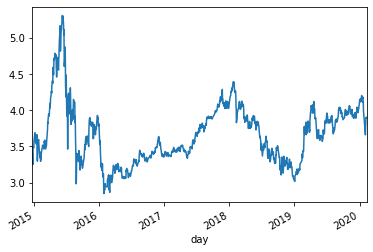

In [8]:
df = get_hist_k_data(code, 1250, verbose=True, plot=True)

## strategy(code, datalen, benjin = 1000, sell_pct=0.1, fee=0.001, dingtou_mode='无脑', sell=True)
定投策略

In [195]:
def strategy(code, datalen, benjin = 1000, sell_pct=0.1, fee=0.001, dingtou_mode='无脑', sell=True):
    """
    每周一3 5 定投1000
    
    dingtou_mode='无脑', '不涨'
    """
    df = get_hist_k_data(code, datalen)
    df['weekday'] = df.day.dt.weekday    
    while df.weekday.iloc[0]!=0:  # 从周一开始定投
        df = df.iloc[1:]
    def ft(s):
        return s[-1]/s[0] -1
    df['指数累计涨幅'] = df.close.expanding().agg(ft)
    df1 = df[df.weekday.isin([0, 2, 4])].copy()
    
    df1['benjin'] = 0
    df1.loc[df1.weekday==0, 'benjin'] = benjin
    df1['open_pct'] = df.open/df.open.shift(1)
    if dingtou_mode=='无脑':
        df1.loc[(df1.weekday.isin([2, 4])), 'benjin'] = benjin  # 不管三七二十一 无脑定投
    elif dingtou_mode=='不涨':
        df1.loc[(df1.weekday.isin([2, 4]))&(df1.open_pct<1), 'benjin'] = benjin  # 只要不涨我就增加定投
    
#     print(df1.iloc[:, 1:].head(50))
    df1['num'] = df1.benjin//df1.open//100*100+100
    df1['benjin_real'] = df1.num*df1.open
    
    df1['sell_price'] = df1.open * (1 + sell_pct)
    df1['sell_money'] = df1.num * df1.sell_price * (1-fee)
    
    df1['sell_flag'] = 0  # 表示未卖出 1表示卖出
    df1['sell_flag1'] = 0  # 表示未卖出 1表示卖出
    df1['sell_money1'] = 0  # 统计在那个时点卖出的金额
    if sell:
        df1['net_stoct_num_ac'] = 0
        count = 0
        df1_shape = df1.shape[0]
        for i in range(df1_shape):
            if df1.benjin.iloc[i] > 0 and df1.weekday.iloc[i] in [2, 4]:
                count += 1
                if df1.high.iloc[i:].max()>=df1.sell_price.iloc[i]:
                    df1['sell_flag'].iloc[i] = 1
#             dft = df1.iloc[:(i+1)]  # copy的东西尽量不要做修改，不然会发生一些意想不到的错误
            dft = df1.iloc[:(i+1)].copy()  # 不然就这样显示copy一下
            df1['sell_money1'].iloc[i] = dft.loc[(dft.sell_flag1==0)&(dft.benjin>0)&(dft.sell_price<df1.high.iloc[i])&(dft.weekday.isin([2, 4])), 'sell_money'].sum()
            dft.loc[(dft.sell_flag1==0)&(dft.benjin>0)&(dft.sell_price<df1.high.iloc[i])&(dft.weekday.isin([2, 4])), 'sell_flag1']=1
            df1.sell_flag1.iloc[:(i+1)] = dft.sell_flag1
            df1['net_stoct_num_ac'].iloc[i] = (dft.num * (1-dft.sell_flag1)).sum()
        print(count)
    else:
        df1['net_stoct_num_ac'] = (df1.num * (1-df1.sell_flag1)).expanding().sum()  # 
    df1['单次投入实际金额'] = df1.benjin_real - df1.sell_money1
    print(df1.loc[df1.weekday.isin([2, 4])&(df1.benjin!=0), 'sell_flag'].value_counts())
#     print(df1.loc[df1.weekday.isin([2, 4])&(df1.benjin!=0), 'sell_flag1'].value_counts())
    print((df1.sell_flag1==df1.sell_flag).value_counts())
    df1['t'] = 0
    df1.loc[df1.benjin!=0, 't'] = 1
    df1['累计执行定投次数'] = df1.t.expanding().sum()
#     print('累计执行定投次数: {}'.format(df1[df1.benjin!=0].shape[0]))
    df1['t'] = 0
    df1.loc[(df1.benjin!=0)&(df1.sell_flag==0), 't'] = 1
    df1['净执行定投次数'] = df1.t.expanding().sum()
#     print('净执行定投次数: {}'.format(df1[(df1.benjin!=0)&(df1.sell_flag==0)].shape[0]))
    df1['累计投入本金'] = df1.benjin_real.expanding().sum()
#     print('累计投入本金: {}'.format(df1.benjin_real.sum()))
    df1['t'] = 0
    df1.loc[(df1.benjin!=0)&(df1.sell_flag==0), 't'] = 1
    df1['t'] = df1.t * df1.benjin_real
    df1['净投入本金'] = df1.t.expanding().sum()
    df1['累计实际净投入本金'] = df1.单次投入实际金额.expanding().sum()  # 买入金额 - 卖出金额
#     net_benjin = df1.loc[(df1.benjin!=0)&(df1.sell_flag==0), 'benjin_real'].sum()
#     print('净投入本金: {}---------------------'.format(net_benjin))
    df1['累计买入股数'] = df1.num.expanding().sum()
#     print('累计买入股数: {}'.format(df1.num.sum()))
    df1['t'] = 0
    df1.loc[(df1.benjin!=0)&(df1.sell_flag==0), 't'] = 1
    df1['t'] = df1.t * df1.num
    df1['净持股数'] = df1.t.expanding().sum()
#     print('净持股数: {}'.format(df1.loc[(df1.benjin!=0)&(df1.sell_flag==0), 'num'].sum()))
    df1['现在持股市值'] = df1.close*df1.净持股数
    df1['现在持股市值_real'] = df1.close*df1.net_stoct_num_ac
#     shizhi = df1.close.iloc[-1]*df1.loc[(df1.benjin!=0)&(df1.sell_flag==0), 'num'].sum()
#     print('现在持股市值: {}'.format(shizhi))
    df1['t'] = df1.sell_flag * df1.sell_price * df1.num * (1-fee)
    df1['累计卖出金额'] = df1.t.expanding().sum()
    df1['累计卖出获利'] = df1['累计卖出金额'] - (df1['累计投入本金']-df1['净投入本金'])
#     sell_val = (df1.sell_flag * df1.sell_price * df1.num ).sum()
#     print('累计卖出金额: {}'.format(sell_val*(1-fee)))
#     print('累计卖出手续费: {}'.format(sell_val*fee))
#     sell_val = sell_val*(1-fee)
    df1['累计绝对收益'] = df1['现在持股市值']+df1['累计卖出金额']-df1['累计投入本金']
    df1['累计绝对收益_real'] = df1['现在持股市值_real']-df1['累计实际净投入本金']
#     print('---------累计绝对收益: {}------------------------------------'.format(shizhi+sell_val-df1.benjin_real.sum()))
#     df1.loc[df1.净投入本金==0, '净投入本金']=benjin
    df1['累计收益率'] = df1['累计绝对收益']/(df1['净投入本金'])
    df1['累计收益率_real'] = df1['累计绝对收益']/(df1['累计实际净投入本金'])
    df1['持仓成本'] = (df1['净投入本金']-df1['累计卖出获利'])/df1['净持股数'] 
    df1['持仓成本_real'] = df1['累计实际净投入本金']/df1['net_stoct_num_ac'] 
#     print('累计收益率: {}'.format((shizhi+sell_val-df1.benjin_real.sum())/net_benjin))  
#     print('简单年化收益率: {}'.format(((shizhi+sell_val-df1.benjin_real.sum())/net_benjin)/(datalen/250)))       
    
#     print('期间指数涨幅: {}'.format(zs_ratio)) 
    return df1

# sh510300

## 只买不卖

### 250

In [155]:
# 如果只买不卖，在震荡市里会被打爆！
code = 'sh510300'
dff = strategy(code, 250, 10000, dingtou_mode='无脑', sell=False)

0    95
Name: sell_flag, dtype: int64
True    147
dtype: int64


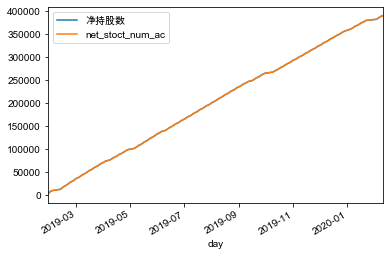

In [156]:
dff[['净持股数', 'net_stoct_num_ac']].plot()

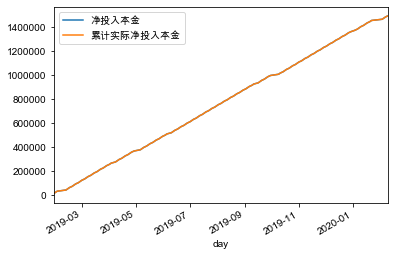

In [157]:
dff[['净投入本金','累计实际净投入本金']].plot()

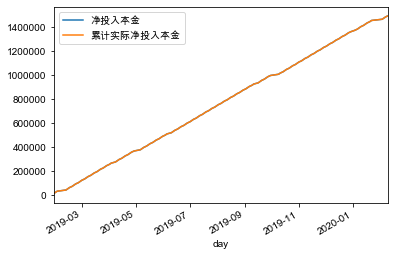

In [158]:
dff[['净投入本金','累计实际净投入本金']].plot()

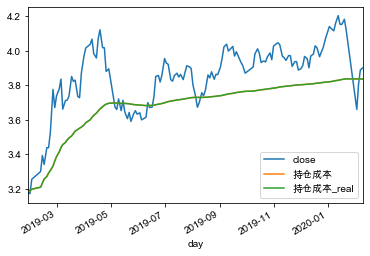

In [159]:
dff[['close','持仓成本','持仓成本_real']].plot()

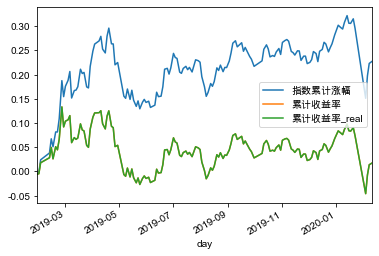

In [161]:
dff[['指数累计涨幅','累计收益率','累计收益率_real']].plot()

In [160]:
dff[['指数累计涨幅','累计收益率','累计收益率_real']].tail(2)

,指数累计涨幅,累计收益率,累计收益率_real
day,,,
2020-02-07,0.223026,0.0137184,0.0137184
2020-02-10,0.227115,0.0170503,0.0170503


In [152]:
dff.tail(2)

,close,day,high,low,open,volume,weekday,指数累计涨幅,benjin,open_pct,num,benjin_real,sell_price,sell_money,sell_flag,sell_flag1,sell_money1,net_stoct_num_ac,单次投入实际金额,t,累计执行定投次数,净执行定投次数,累计投入本金,净投入本金,累计实际净投入本金,累计买入股数,净持股数,现在持股市值,累计卖出金额,累计卖出获利,累计绝对收益,累计收益率,累计收益率_real,持仓成本,持仓成本_real
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-07,3.888,2020-02-07,3.892,3.844,3.87,346989051,4,0.223026,10000,1.01229,2600,10062,4.257,11057.1,0,0,0,0,10062,0,146.0,146.0,1487745.7,1487745.7,1487745.7,387900.0,387900.0,1.50816e+06,0.0,0.0,20409.5,0.0137184,0.0137184,3.835385,inf
2020-02-10,3.901,2020-02-10,3.91,3.851,3.868,398519147,0,0.227115,10000,0.999483,2600,10056.8,4.2548,11051.4,0,0,0,0,10056.8,0,147.0,147.0,1497802.5,1497802.5,1497802.5,390500.0,390500.0,1.52334e+06,0.0,0.0,25538,0.0170503,0.0170503,3.835602,inf


### 500

In [178]:
# 如果只买不卖，在震荡市里会被打爆！
code = 'sh510300'
dff = strategy(code, 500, 10000, dingtou_mode='无脑', sell=False)

0    198
Name: sell_flag, dtype: int64
True    298
dtype: int64


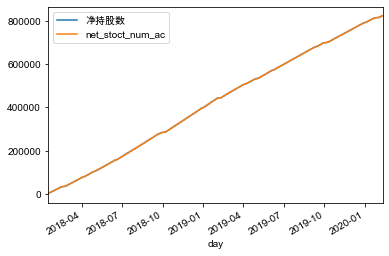

In [179]:
dff[['净持股数', 'net_stoct_num_ac']].plot()

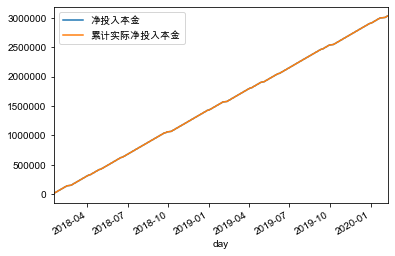

In [180]:
dff[['净投入本金','累计实际净投入本金']].plot()

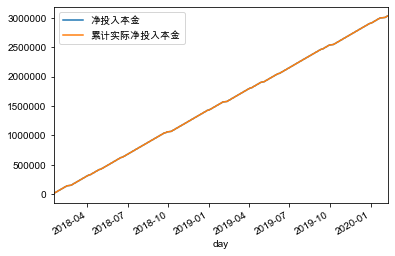

In [181]:
dff[['净投入本金','累计实际净投入本金']].plot()

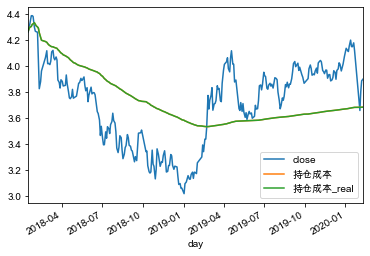

In [182]:
dff[['close','持仓成本','持仓成本_real']].plot()

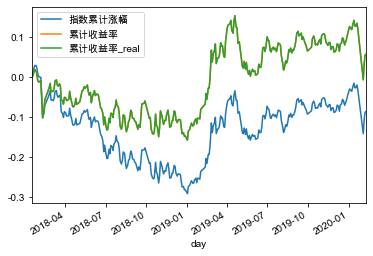

In [183]:
dff[['指数累计涨幅','累计收益率','累计收益率_real']].plot()

In [184]:
dff[['指数累计涨幅','累计收益率','累计收益率_real']].tail(2)

,指数累计涨幅,累计收益率,累计收益率_real
day,,,
2020-02-07,-0.088394,0.0553257,0.0553257
2020-02-10,-0.085346,0.0586875,0.0586875


In [185]:
dff.tail(2)

,close,day,high,low,open,volume,weekday,指数累计涨幅,benjin,open_pct,num,benjin_real,sell_price,sell_money,sell_flag,sell_flag1,sell_money1,net_stoct_num_ac,单次投入实际金额,t,累计执行定投次数,净执行定投次数,累计投入本金,净投入本金,累计实际净投入本金,累计买入股数,净持股数,现在持股市值,累计卖出金额,累计卖出获利,累计绝对收益,累计收益率,累计收益率_real,持仓成本,持仓成本_real
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-07,3.888,2020-02-07,3.892,3.844,3.87,346989051,4,-0.088394,10000,1.01229,2600,10062,4.257,11057.1,0,0,0,820800.0,10062,0,297.0,297.0,3023967.2,3023967.2,3023967.2,820800.0,820800.0,3.19127e+06,0.0,0.0,167303,0.0553257,0.0553257,3.684171,3.684171
2020-02-10,3.901,2020-02-10,3.91,3.851,3.868,398519147,0,-0.085346,10000,0.999483,2600,10056.8,4.2548,11051.4,0,0,0,823400.0,10056.8,0,298.0,298.0,3034024.0,3034024.0,3034024.0,823400.0,823400.0,3.21208e+06,0.0,0.0,178059,0.0586875,0.0586875,3.684751,3.684751


## 250, 10000,sell_pct=0.05

In [196]:
code = 'sh510300'

dff = strategy(code, 250, 10000,sell_pct=0.05, dingtou_mode='无脑')

95
1    75
0    20
Name: sell_flag, dtype: int64
True    147
dtype: int64


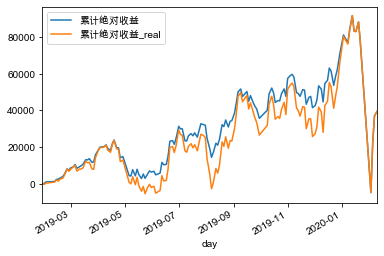

In [197]:
dff[['累计绝对收益', '累计绝对收益_real']].plot()

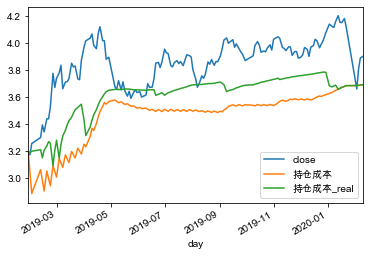

In [175]:
dff[['close','持仓成本','持仓成本_real']].plot()

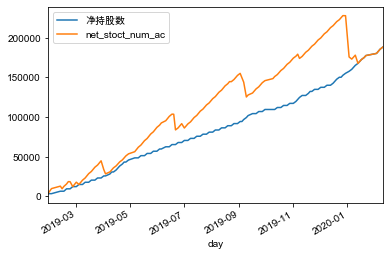

In [173]:
dff[['净持股数', 'net_stoct_num_ac']].plot()

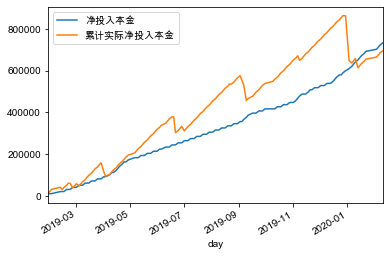

In [174]:
dff[['净投入本金','累计实际净投入本金']].plot()

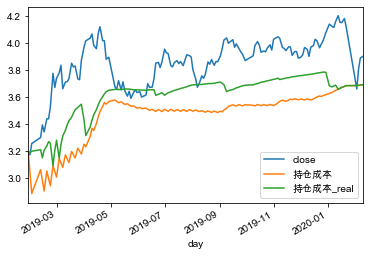

In [175]:
dff[['close','持仓成本','持仓成本_real']].plot()

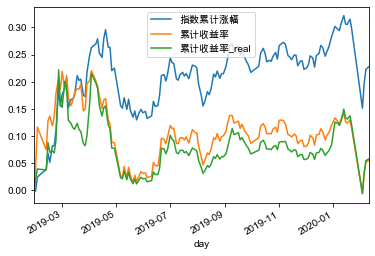

In [176]:
dff[['指数累计涨幅','累计收益率','累计收益率_real']].plot()

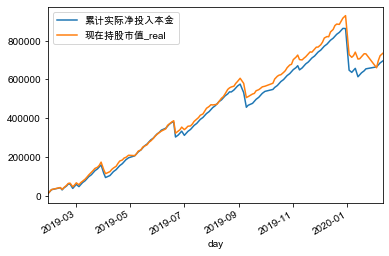

In [200]:
dff[['累计实际净投入本金', '现在持股市值_real']].plot()

In [199]:
dff[['累计实际净投入本金', '现在持股市值_real','累计绝对收益', '累计绝对收益_real', '指数累计涨幅','累计收益率','累计收益率_real']].tail(2)

,累计实际净投入本金,现在持股市值_real,累计绝对收益,累计绝对收益_real,指数累计涨幅,累计收益率,累计收益率_real
day,,,,,,,
2020-02-07,684552.831865,721613,37060,37060,0.223026,0.0513272,0.0541375
2020-02-10,694609.631865,734168,39558.6,39558.6,0.227115,0.054035,0.0569508


## 500, 10000,sell_pct=0.05

In [186]:
code = 'sh510300'

dff = strategy(code, 500, 10000,sell_pct=0.05, dingtou_mode='无脑')

198
1    163
0     35
Name: sell_flag, dtype: int64
True    298
dtype: int64


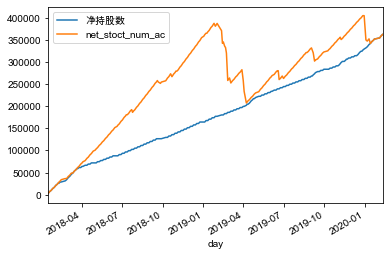

In [187]:
dff[['净持股数', 'net_stoct_num_ac']].plot()

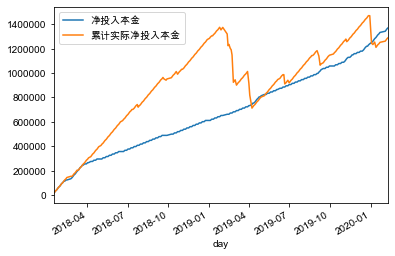

In [188]:
dff[['净投入本金','累计实际净投入本金']].plot()

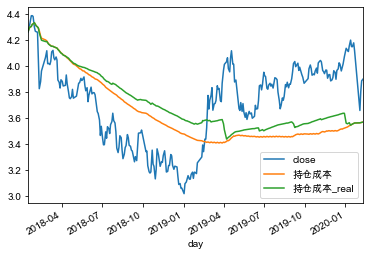

In [189]:
dff[['close','持仓成本','持仓成本_real']].plot()

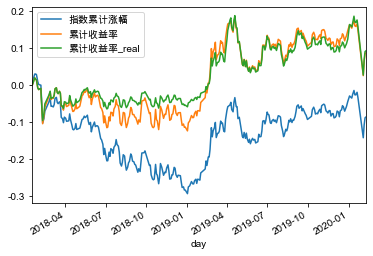

In [190]:
dff[['指数累计涨幅','累计收益率','累计收益率_real']].plot()

In [191]:
dff[['指数累计涨幅','累计收益率','累计收益率_real']].tail(2)

,指数累计涨幅,累计收益率,累计收益率_real
day,,,
2020-02-07,-0.088394,0.0844944,0.0898485
2020-02-10,-0.085346,0.0873402,0.0928315


# sz159915

## 500, sell_pct=0.1

In [84]:
code = 'sz159915'

dff500 = strategy(code, 500, 10000,sell_pct=0.1, dingtou_mode='无脑')

198
1    191
0      7
Name: sell_flag, dtype: int64


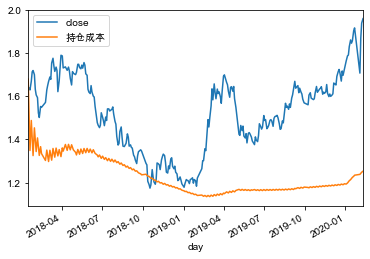

In [85]:
dff500[['close','持仓成本']].plot()

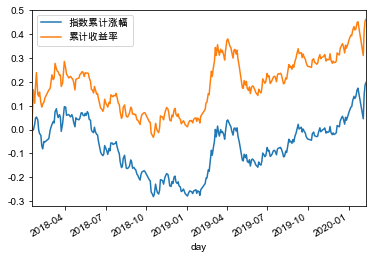

In [86]:
dff500[['指数累计涨幅','累计收益率']].plot()

In [87]:
dff500.tail(2)

,close,day,high,low,open,volume,weekday,指数累计涨幅,benjin,open_pct,...,累计投入本金,净投入本金,累计买入股数,净持股数,现在持股市值,累计卖出金额,累计卖出获利,累计绝对收益,累计收益率,持仓成本
day,,,,,,,,,,,,,,,,,,,,,
2020-02-07,1.94,2020-02-07,1.949,1.9,1.932,502075775,4,0.187271,10000,1.04151,...,2992651.9,1067960.1,2000600.0,703400.0,1.3646e+06,2.115044e+06,190352.01902,486988,0.455998,1.247666
2020-02-10,1.961,2020-02-10,1.966,1.924,1.938,437752260,0,0.200122,10000,1.00311,...,3002729.5,1078037.7,2005800.0,708600.0,1.38956e+06,2.115044e+06,190352.01902,501879,0.465549,1.252732


## 250, sell_pct=0.1

In [80]:
code = 'sz159915'

dff500 = strategy(code, 250, 10000,sell_pct=0.1, dingtou_mode='无脑')

95
1    88
0     7
Name: sell_flag, dtype: int64


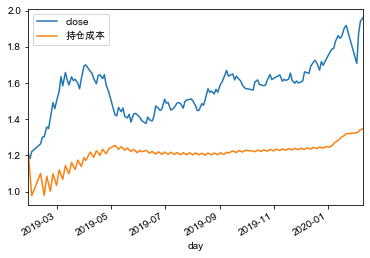

In [81]:
dff500[['close','持仓成本']].plot()

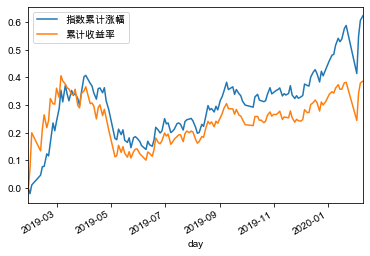

In [82]:
dff500[['指数累计涨幅','累计收益率']].plot()

In [83]:
dff500.tail(2)

,close,day,high,low,open,volume,weekday,指数累计涨幅,benjin,open_pct,...,累计投入本金,净投入本金,累计买入股数,净持股数,现在持股市值,累计卖出金额,累计卖出获利,累计绝对收益,累计收益率,持仓成本
day,,,,,,,,,,,,,,,,,,,,,
2020-02-07,1.94,2020-02-07,1.949,1.9,1.932,502075775,4,0.605960,10000,1.04151,...,1471096.9,584151.9,948300.0,370200.0,718188,974663.8605,87718.8605,221755,0.379619,1.340986
2020-02-10,1.961,2020-02-10,1.966,1.924,1.938,437752260,0,0.623344,10000,1.00311,...,1481174.5,594229.5,953500.0,375400.0,736159,974663.8605,87718.8605,229649,0.386465,1.349256


In [63]:
code = 'sh510300'

dff500 = strategy(code, 1250, 10000,sell_pct=0.05, dingtou_mode='无脑')

500
1    451
0     49
Name: sell_flag, dtype: int64


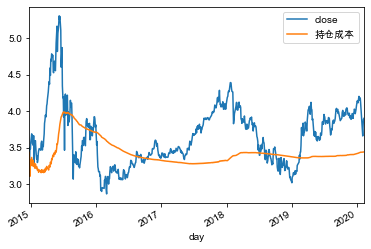

In [64]:
dff500[['close','持仓成本']].plot()

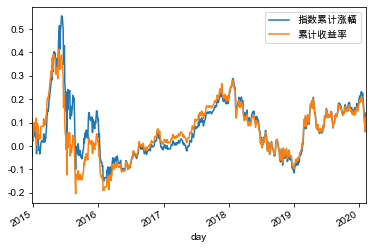

In [65]:
dff500[['指数累计涨幅','累计收益率']].plot()

In [66]:
dff500.tail(2)

,close,day,high,low,open,volume,weekday,指数累计涨幅,benjin,open_pct,...,累计投入本金,净投入本金,累计买入股数,净持股数,现在持股市值,累计卖出金额,累计卖出获利,累计绝对收益,累计收益率,持仓成本
day,,,,,,,,,,,,,,,,,,,,,
2020-02-07,3.888,2020-02-07,3.892,3.844,3.87,346989051,4,0.140176,10000,1.01229,...,7575433.2,2982337.8,2091200.0,801800.0,3.1174e+06,4.817927e+06,224832.01983,359893,0.120675,3.439144
2020-02-10,3.901,2020-02-10,3.91,3.851,3.868,398519147,0,0.143988,10000,0.999483,...,7585490.0,2992394.6,2093800.0,804400.0,3.13796e+06,4.817927e+06,224832.01983,370402,0.123781,3.440530


In [68]:
code = 'sh510300'

dff500 = strategy(code, 1125, 10000,sell_pct=0.05, dingtou_mode='无脑')

450
1    410
0     40
Name: sell_flag, dtype: int64


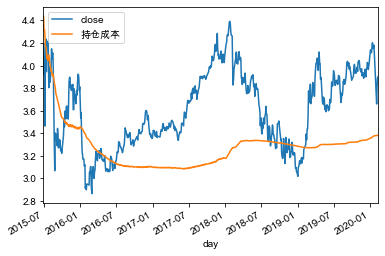

In [69]:
dff500[['close','持仓成本']].plot()

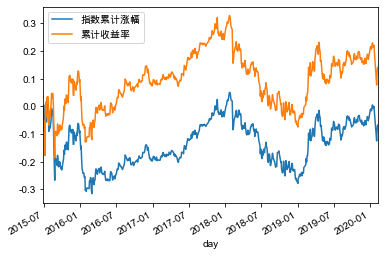

In [70]:
dff500[['指数累计涨幅','累计收益率']].plot()

In [71]:
dff500.tail(2)

,close,day,high,low,open,volume,weekday,指数累计涨幅,benjin,open_pct,...,累计投入本金,净投入本金,累计买入股数,净持股数,现在持股市值,累计卖出金额,累计卖出获利,累计绝对收益,累计收益率,持仓成本
day,,,,,,,,,,,,,,,,,,,,,
2020-02-07,3.888,2020-02-07,3.892,3.844,3.87,346989051,4,-0.070301,10000,1.01229,...,6820618.0,2645924.5,1903300.0,722000.0,2.80714e+06,4.379045e+06,204351.246825,365563,0.138161,3.381680
2020-02-10,3.901,2020-02-10,3.91,3.851,3.868,398519147,0,-0.067193,10000,0.999483,...,6830674.8,2655981.3,1905900.0,724600.0,2.82666e+06,4.379045e+06,204351.246825,375035,0.141204,3.383425


In [32]:
code = 'sh510300'

dff = strategy(code, 500, 10000,sell_pct=0.01, dingtou_mode='无脑')

198
1    192
0      6
Name: sell_flag, dtype: int64


In [ ]:
dff[['指数累计涨幅','累计收益率']].plot()

In [316]:
code = 'sh510300'

strategy1(code, 1250, 10000,sell_pct=0.02, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


501
1    485
0     16
Name: sell_flag, dtype: int64
累计执行定投次数: 745
净执行定投次数: 260
累计投入本金: 7585594.199999996
净投入本金: 2646178.0000000005---------------------
累计买入股数: 2094200.0
净持股数: 722400.0
现在持股市值: 2808691.1999999997
累计卖出金额: 5033166.319475997
累计卖出手续费: 5038.204523999998
---------累计绝对收益: 256263.31947600003------------------------------------
累计收益率: 0.09684281234142222
简单年化收益率: 0.019368562468284445
期间指数涨幅: 0.14893617021276606


In [317]:
code = 'sh510300'

strategy1(code, 1250, 10000,sell_pct=0.03, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


501
1    473
0     28
Name: sell_flag, dtype: int64
累计执行定投次数: 745
净执行定投次数: 272
累计投入本金: 7585594.199999996
净投入本金: 2769484.200000001---------------------
累计买入股数: 2094200.0
净持股数: 750500.0
现在持股市值: 2917944.0
累计卖出金额: 4955632.706700004
累计卖出手续费: 4960.593300000004
---------累计绝对收益: 287982.50670000724------------------------------------
累计收益率: 0.10398416669068093
简单年化收益率: 0.020796833338136186
期间指数涨幅: 0.14893617021276606


In [318]:
code = 'sh510300'

strategy1(code, 1250, 10000,sell_pct=0.04, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


501
1    463
0     38
Name: sell_flag, dtype: int64
累计执行定投次数: 745
净执行定投次数: 282
累计投入本金: 7585594.199999996
净投入本金: 2871548.700000001---------------------
累计买入股数: 2094200.0
净持股数: 774400.0
现在持股市值: 3010867.1999999997
累计卖出金额: 4897704.71268
累计卖出手续费: 4902.60732
---------累计绝对收益: 322977.7126800036------------------------------------
累计收益率: 0.11247509494789466
简单年化收益率: 0.02249501898957893
期间指数涨幅: 0.14893617021276606


In [319]:
code = 'sh510300'

strategy1(code, 1250, 10000,sell_pct=0.05, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


501
1    452
0     49
Name: sell_flag, dtype: int64
累计执行定投次数: 745
净执行定投次数: 293
累计投入本金: 7585594.199999996
净投入本金: 2982337.800000001---------------------
累计买入股数: 2094200.0
净持股数: 801800.0
现在持股市值: 3117398.4
累计卖出金额: 4828585.800779999
累计卖出手续费: 4833.419219999999
---------累计绝对收益: 360390.0007800022------------------------------------
累计收益率: 0.1208414421666124
简单年化收益率: 0.024168288433322478
期间指数涨幅: 0.14893617021276606


In [322]:
code = 'sh510300'

strategy1(code, 1250, 10000,sell_pct=0.05, dingtou_mode='不涨')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


230
1    216
0     14
Name: sell_flag, dtype: int64
累计执行定投次数: 474
净执行定投次数: 258
累计投入本金: 4925971.699999999
净投入本金: 2625702.7000000007---------------------
累计买入股数: 1366300.0
净持股数: 717600.0
现在持股市值: 2790028.8
累计卖出金额: 2307790.0698300023
累计卖出手续费: 2310.1001700000024
---------累计绝对收益: 171847.16983000282------------------------------------
累计收益率: 0.06544806837042243
简单年化收益率: 0.013089613674084486
期间指数涨幅: 0.14893617021276606


In [320]:
code = 'sh510300'

strategy1(code, 1250, 10000, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


501
1    367
0    134
Name: sell_flag, dtype: int64
累计执行定投次数: 745
净执行定投次数: 378
累计投入本金: 7585594.199999996
净投入本金: 3850118.2---------------------
累计买入股数: 2094200.0
净持股数: 1020100.0
现在持股市值: 3966148.8
累计卖出金额: 4104914.5764000025
累计卖出手续费: 4109.023600000002
---------累计绝对收益: 485469.1764000058------------------------------------
累计收益率: 0.1260920187852949
简单年化收益率: 0.025218403757058982
期间指数涨幅: 0.14893617021276606


In [321]:
code = 'sh510300'

strategy1(code, 1250, 10000,sell_pct=0.2, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


501
1    262
0    239
Name: sell_flag, dtype: int64
累计执行定投次数: 745
净执行定投次数: 483
累计投入本金: 7585594.199999996
净投入本金: 4921571.999999998---------------------
累计买入股数: 2094200.0
净持股数: 1298900.0
现在持股市值: 5050123.2
累计卖出金额: 3193629.8133600024
累计卖出手续费: 3196.8266400000025
---------累计绝对收益: 658158.8133600065------------------------------------
累计收益率: 0.13372938836615755
简单年化收益率: 0.02674587767323151
期间指数涨幅: 0.14893617021276606


In [280]:
code = 'sh510300'

strategy1(code, 500, 10000,sell_pct=0.01, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


199
1    192
0      7
Name: sell_flag, dtype: int64
累计执行定投次数: 298
净执行定投次数: 106
累计投入本金: 3034167.200000002
净投入本金: 1079304.0999999996---------------------
累计买入股数: 823200.0
净持股数: 289800.0
现在持股市值: 1126742.4
累计卖出金额: 1972437.3192689999
累计卖出手续费: 1974.411731
---------累计绝对收益: 65012.519268997945------------------------------------
累计收益率: 0.02142680840693223
简单年化收益率: 0.010713404203466115
期间指数涨幅: -0.09010063187456119


In [281]:
code = 'sh510300'

strategy1(code, 500, 10000,sell_pct=0.02, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


199
1    187
0     12
Name: sell_flag, dtype: int64
累计执行定投次数: 298
净执行定投次数: 111
累计投入本金: 3034167.200000002
净投入本金: 1130363.0999999996---------------------
累计买入股数: 823200.0
净持股数: 302000.0
现在持股市值: 1174176.0
累计卖出金额: 1939938.3018179988
累计卖出手续费: 1941.880181999999
---------累计绝对收益: 79947.1018179967------------------------------------
累计收益率: 0.0263489440588498
简单年化收益率: 0.0131744720294249
期间指数涨幅: -0.09010063187456119


In [282]:
code = 'sh510300'

strategy1(code, 500, 10000,sell_pct=0.03, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


199
1    181
0     18
Name: sell_flag, dtype: int64
累计执行定投次数: 298
净执行定投次数: 117
累计投入本金: 3034167.200000002
净投入本金: 1191961.4999999998---------------------
累计买入股数: 823200.0
净持股数: 317000.0
现在持股市值: 1232496.0
累计卖出金额: 1895574.3991290003
累计卖出手续费: 1897.4718710000004
---------累计绝对收益: 93903.19912899844------------------------------------
累计收益率: 0.0309485908123317
简单年化收益率: 0.01547429540616585
期间指数涨幅: -0.09010063187456119


In [283]:
code = 'sh510300'

strategy1(code, 500, 10000,sell_pct=0.04, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


199
1    173
0     26
Name: sell_flag, dtype: int64
累计执行定投次数: 298
净执行定投次数: 125
累计投入本金: 3034167.200000002
净投入本金: 1273343.9999999998---------------------
累计买入股数: 823200.0
净持股数: 336900.0
现在持股市值: 1309867.2
累计卖出金额: 1829424.8718719995
累计卖出手续费: 1831.2561279999995
---------累计绝对收益: 105124.8718719976------------------------------------
累计收益率: 0.03464702666088981
简单年化收益率: 0.017323513330444906
期间指数涨幅: -0.09010063187456119


In [284]:
code = 'sh510300'

strategy1(code, 500, 10000,sell_pct=0.05, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


199
1    163
0     36
Name: sell_flag, dtype: int64
累计执行定投次数: 298
净执行定投次数: 135
累计投入本金: 3034167.200000002
净投入本金: 1373971.5---------------------
累计买入股数: 823200.0
净持股数: 361900.0
现在持股市值: 1407067.2
累计卖出金额: 1741462.2795150005
累计卖出手续费: 1743.2054850000006
---------累计绝对收益: 114362.2795149982------------------------------------
累计收益率: 0.03769148895782615
简单年化收益率: 0.018845744478913073
期间指数涨幅: -0.09010063187456119


In [286]:
code = 'sh510300'

strategy1(code, 500, 10000,sell_pct=0.2, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


199
0    138
1     61
Name: sell_flag, dtype: int64
累计执行定投次数: 298
净执行定投次数: 237
累计投入本金: 3034167.200000002
净投入本金: 2414364.800000001---------------------
累计买入股数: 823200.0
净持股数: 634400.0
现在持股市值: 2466547.1999999997
累计卖出金额: 743019.11712
累计卖出手续费: 743.76288
---------累计绝对收益: 175399.11711999774------------------------------------
累计收益率: 0.05780799328395525
简单年化收益率: 0.028903996641977625
期间指数涨幅: -0.09010063187456119


In [285]:
code = 'sh510300'

strategy1(code, 500, 10000, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


199
1    106
0     93
Name: sell_flag, dtype: int64
累计执行定投次数: 298
净执行定投次数: 192
累计投入本金: 3034167.200000002
净投入本金: 1955845.8000000003---------------------
累计买入股数: 823200.0
净持股数: 510800.0
现在持股市值: 1985990.4
累计卖出金额: 1184967.38646
累计卖出手续费: 1186.15354
---------累计绝对收益: 136790.58645999804------------------------------------
累计收益率: 0.045083404256692994
简单年化收益率: 0.022541702128346497
期间指数涨幅: -0.09010063187456119


In [307]:
code = 'sh510300'

strategy1(code, 250, 10000,sell_pct=0.01, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


97
1    93
0     4
Name: sell_flag, dtype: int64
累计执行定投次数: 148
净执行定投次数: 55
累计投入本金: 1507896.1
净投入本金: 559662.5999999999---------------------
累计买入股数: 394300.0
净持股数: 145400.0
现在持股市值: 565315.2
累计卖出金额: 956758.119165
累计卖出手续费: 957.7158350000001
---------累计绝对收益: 14177.2191649999------------------------------------
累计收益率: 0.025331725159051015
简单年化收益率: 0.025331725159051015
期间指数涨幅: 0.24019138755980873


In [308]:
code = 'sh510300'

strategy1(code, 250, 10000,sell_pct=0.02, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


97
1    90
0     7
Name: sell_flag, dtype: int64
累计执行定投次数: 148
净执行定投次数: 58
累计投入本金: 1507896.1
净投入本金: 590612.6---------------------
累计买入股数: 394300.0
净持股数: 152900.0
现在持股市值: 594475.2
累计卖出金额: 934693.5408300003
累计卖出手续费: 935.6291700000003
---------累计绝对收益: 21272.640830000164------------------------------------
累计收益率: 0.03601792584513125
简单年化收益率: 0.03601792584513125
期间指数涨幅: 0.24019138755980873


In [309]:
code = 'sh510300'

strategy1(code, 250, 10000,sell_pct=0.03, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


97
1    89
0     8
Name: sell_flag, dtype: int64
累计执行定投次数: 148
净执行定投次数: 59
累计投入本金: 1507896.1
净投入本金: 600829.4---------------------
累计买入股数: 394300.0
净持股数: 155600.0
现在持股市值: 604972.7999999999
累计卖出金额: 933344.422299
累计卖出手续费: 934.2787010000001
---------累计绝对收益: 30421.12229899969------------------------------------
累计收益率: 0.050631880362378555
简单年化收益率: 0.050631880362378555
期间指数涨幅: 0.24019138755980873


In [310]:
code = 'sh510300'

strategy1(code, 250, 10000,sell_pct=0.04, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


97
1    85
0    12
Name: sell_flag, dtype: int64
累计执行定投次数: 148
净执行定投次数: 63
累计投入本金: 1507896.1
净投入本金: 641526.9---------------------
累计买入股数: 394300.0
净持股数: 165600.0
现在持股市值: 643852.7999999999
累计卖出金额: 900122.9440320001
累计卖出手续费: 901.0239680000001
---------累计绝对收益: 36079.6440320001------------------------------------
累计收益率: 0.05624026682591189
简单年化收益率: 0.05624026682591189
期间指数涨幅: 0.24019138755980873


In [339]:
code = 'sh510300'

strategy1(code, 250, 5000,sell_pct=0.05, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


97
1    77
0    20
Name: sell_flag, dtype: int64
累计执行定投次数: 148
净执行定投次数: 71
累计投入本金: 766618.6000000002
净投入本金: 369357.1999999999---------------------
累计买入股数: 200400.0
净持股数: 94900.0
现在持股市值: 368971.2
累计卖出金额: 416707.34553
累计卖出手续费: 417.12447
---------累计绝对收益: 19059.945529999794------------------------------------
累计收益率: 0.051603016077660865
简单年化收益率: 0.051603016077660865
期间指数涨幅: 0.24019138755980873


In [347]:
code = 'sz159915'
strategy1(code, 250, 5000,sell_pct=0.1, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


97
1    90
0     7
Name: sell_flag, dtype: int64
累计执行定投次数: 148
净执行定投次数: 58
累计投入本金: 751955.7
净投入本金: 294470.20000000007---------------------
累计买入股数: 486600.0
净持股数: 186600.0
现在持股市值: 362004.0
累计卖出金额: 502730.8159499998
累计卖出手续费: 503.2340499999998
---------累计绝对收益: 112779.11594999977------------------------------------
累计收益率: 0.38298991188242393
简单年化收益率: 0.38298991188242393
期间指数涨幅: 0.6207184628237259


In [313]:
code = 'sh510300'

strategy1(code, 250, 10000, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


97
0    61
1    36
Name: sell_flag, dtype: int64
累计执行定投次数: 148
净执行定投次数: 112
累计投入本金: 1507896.1
净投入本金: 1141069.9---------------------
累计买入股数: 394300.0
净持股数: 292600.0
现在持股市值: 1137628.8
累计卖出金额: 403105.3111800001
累计卖出手续费: 403.50882000000007
---------累计绝对收益: 32838.011179999914------------------------------------
累计收益率: 0.02877826431141503
简单年化收益率: 0.02877826431141503
期间指数涨幅: 0.24019138755980873


In [203]:
code = 'sh510300'

strategy1(code, 250, 10000, dingtou_mode='不涨')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


44
0    28
1    16
Name: sell_flag, dtype: int64
累计执行定投次数: 95
净执行定投次数: 79
累计投入本金: 989297.7
净投入本金: 805468.0999999997
累计买入股数: 258100.0
净持股数: 208000.0
现在持股市值: 808704.0
累计卖出金额: 179912.37
累计收益: 183148.27000000025
累计收益率: 0.22738115885657084
简单年化收益率: 0.22738115885657084
期间指数涨幅: 0.24019138755980873


In [198]:
code = 'sh510300'

strategy1(code, 1250, 10000)

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


501
1    367
0    134
Name: sell_flag, dtype: int64
累计执行定投次数: 745
净执行定投次数: 378
累计投入本金: 7585594.199999996
净投入本金: 3850118.2
累计买入股数: 2094200.0
净持股数: 1020100.0
现在持股市值: 3966148.8
累计卖出金额: 4109023.6000000024
累计收益: 4225054.200000002
累计收益率: 1.0973829842418867
简单年化收益率: 0.21947659684837734
期间指数涨幅: 0.14893617021276606


In [201]:
code = 'sh510300'

strategy1(code, 1250, 10000, dingtou_mode='不涨')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


230
1    176
0     54
Name: sell_flag, dtype: int64
累计执行定投次数: 474
净执行定投次数: 298
累计投入本金: 4925971.699999999
净投入本金: 3034641.800000001
累计买入股数: 1366300.0
净持股数: 821200.0
现在持股市值: 3192825.6
累计卖出金额: 1970271.9300000004
累计收益: 2128455.729999999
累计收益率: 0.7013861504181476
简单年化收益率: 0.14027723008362952
期间指数涨幅: 0.14893617021276606


In [180]:
code = 'sz159915'

strategy1(get_hist_k_data(code, 250), 10000)

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


34
1    32
0     2
Name: sell_flag, dtype: int64
累计执行定投次数: 85
净执行定投次数: 53
累计投入本金: 865835.7000000001
净投入本金: 533691.3
累计买入股数: 562400.0
净持股数: 343000.0
现在持股市值: 665420.0
累计卖出金额: 354494.36
累计收益: 486223.05999999994
累计收益率: 0.9110567475992206
期间指数涨幅: 0.6207184628237259


In [149]:
strategy1(get_hist_k_data(code, 500))

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


95
1    54
0    41
Name: sell_flag, dtype: int64
累计执行定投次数: 194
净执行定投次数: 140
累计投入本金: 266106.6
净投入本金: 165211.59999999995
累计买入股数: 72300.0
净持股数: 43800.0
现在持股市值: 170294.4
累计卖出金额: 68189.33
累计收益: 0.4435047539034793


In [150]:
strategy1(get_hist_k_data(code, 750))

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


132
1    85
0    47
Name: sell_flag, dtype: int64
累计执行定投次数: 278
净执行定投次数: 193
累计投入本金: 383754.9999999999
净投入本金: 224978.49999999994
累计买入股数: 104000.0
净持股数: 59700.0
现在持股市值: 232113.6
累计卖出金额: 105235.13000000002
累计收益: 0.49947097167062693


In [168]:
code = 'sz159915'

In [169]:
strategy1(get_hist_k_data(code, 250), 10000)

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


34
1    32
0     2
Name: sell_flag, dtype: int64
累计执行定投次数: 85
净执行定投次数: 53
累计投入本金: 865835.7000000001
净投入本金: 533691.3
累计买入股数: 562400.0
净持股数: 343000.0
现在持股市值: 665420.0
累计卖出金额: 354494.36
累计收益: 486223.05999999994
累计收益率: 0.9110567475992206


In [170]:
strategy1(get_hist_k_data(code, 500))

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


82
1    80
0     2
Name: sell_flag, dtype: int64
累计执行定投次数: 181
净执行定投次数: 101
累计投入本金: 212961.8
净投入本金: 108935.30000000005
累计买入股数: 142900.0
净持股数: 72400.0
现在持股市值: 140456.0
累计卖出金额: 94685.03000000003
累计收益: 126205.72999999998
累计收益率: 1.158538416840087


In [171]:
strategy1(get_hist_k_data(code, 750))

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


134
1    109
0     25
Name: sell_flag, dtype: int64
累计执行定投次数: 280
净执行定投次数: 171
累计投入本金: 328194.39999999973
净投入本金: 184533.19999999998
累计买入股数: 208700.0
净持股数: 115000.0
现在持股市值: 223100.0
累计卖出金额: 128636.75000000003
累计收益: 167203.55000000002
累计收益率: 0.9060892565673822


In [331]:
code = 'sz159915'

strategy1(code, 500, 10000,sell_pct=0.01, dingtou_mode='无脑', sell=False)

0    199
Name: sell_flag, dtype: int64
累计执行定投次数: 298
净执行定投次数: 298
累计投入本金: 3002681.9
净投入本金: 3002681.9---------------------
累计买入股数: 2006500.0
净持股数: 2006500.0
现在持股市值: 3892610.0
累计卖出金额: 0.0
累计卖出手续费: 0.0
---------累计绝对收益: 889928.1000000001------------------------------------
累计收益率: 0.2963777481723922
简单年化收益率: 0.1481888740861961
期间指数涨幅: 0.1513353115727003


In [324]:
code = 'sz159915'

strategy1(code, 500, 10000,sell_pct=0.01, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


199
1    198
0      1
Name: sell_flag, dtype: int64
累计执行定投次数: 298
净执行定投次数: 100
累计投入本金: 3002681.9
净投入本金: 1007219.1---------------------
累计买入股数: 2006500.0
净持股数: 670500.0
现在持股市值: 1300770.0
累计卖出金额: 2013402.0105720013
累计卖出手续费: 2015.4174280000013
---------累计绝对收益: 311490.11057200143------------------------------------
累计收益率: 0.3092575493971485
简单年化收益率: 0.15462877469857425
期间指数涨幅: 0.1513353115727003


In [325]:

strategy1(code, 500, 10000,sell_pct=0.02, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


199
1    198
0      1
Name: sell_flag, dtype: int64
累计执行定投次数: 298
净执行定投次数: 100
累计投入本金: 3002681.9
净投入本金: 1007219.1---------------------
累计买入股数: 2006500.0
净持股数: 670500.0
现在持股市值: 1300770.0
累计卖出金额: 2033336.683943999
累计卖出手续费: 2035.372055999999
---------累计绝对收益: 331424.7839439991------------------------------------
累计收益率: 0.32904934382598494
简单年化收益率: 0.16452467191299247
期间指数涨幅: 0.1513353115727003


In [326]:

strategy1(code, 500, 10000,sell_pct=0.03, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


199
1    198
0      1
Name: sell_flag, dtype: int64
累计执行定投次数: 298
净执行定投次数: 100
累计投入本金: 3002681.9
净投入本金: 1007219.1---------------------
累计买入股数: 2006500.0
净持股数: 670500.0
现在持股市值: 1300770.0
累计卖出金额: 2053271.3573159983
累计卖出手续费: 2055.3266839999983
---------累计绝对收益: 351359.4573159986------------------------------------
累计收益率: 0.3488411382548232
简单年化收益率: 0.1744205691274116
期间指数涨幅: 0.1513353115727003


In [327]:

strategy1(code, 500, 10000,sell_pct=0.04, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


199
1    197
0      2
Name: sell_flag, dtype: int64
累计执行定投次数: 298
净执行定投次数: 101
累计投入本金: 3002681.9
净投入本金: 1017381.9---------------------
累计买入股数: 2006500.0
净持股数: 675900.0
现在持股市值: 1311246.0
累计卖出金额: 2062647.2880000009
累计卖出手续费: 2064.712000000001
---------累计绝对收益: 371211.38800000073------------------------------------
累计收益率: 0.36486926688984805
简单年化收益率: 0.18243463344492403
期间指数涨幅: 0.1513353115727003


In [328]:

strategy1(code, 500, 10000,sell_pct=0.05, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


199
1    196
0      3
Name: sell_flag, dtype: int64
累计执行定投次数: 298
净执行定投次数: 102
累计投入本金: 3002681.9
净投入本金: 1027431.3---------------------
累计买入股数: 2006500.0
净持股数: 681300.0
现在持股市值: 1321722.0
累计卖出金额: 2071939.116869999
累计卖出手续费: 2074.0131299999994
---------累计绝对收益: 390979.2168699992------------------------------------
累计收益率: 0.3805404963524074
简单年化收益率: 0.1902702481762037
期间指数涨幅: 0.1513353115727003


In [329]:

strategy1(code, 500, 10000, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


199
1    191
0      8
Name: sell_flag, dtype: int64
累计执行定投次数: 298
净执行定投次数: 107
累计投入本金: 3002681.9
净投入本金: 1078066.1999999997---------------------
累计买入股数: 2006500.0
净持股数: 709100.0
现在持股市值: 1375654.0
累计卖出金额: 2114960.1927300002
累计卖出手续费: 2117.07727
---------累计绝对收益: 487932.29273000034------------------------------------
累计收益率: 0.4525995646000222
简单年化收益率: 0.2262997823000111
期间指数涨幅: 0.1513353115727003


In [332]:
code = 'sz159915'

strategy1(code, 250, 10000,sell_pct=0.01, dingtou_mode='无脑',sell=False)

0    97
Name: sell_flag, dtype: int64
累计执行定投次数: 148
净执行定投次数: 148
累计投入本金: 1491219.6999999997
净投入本金: 1491219.6999999997---------------------
累计买入股数: 965000.0
净持股数: 965000.0
现在持股市值: 1872100.0
累计卖出金额: 0.0
累计卖出手续费: 0.0
---------累计绝对收益: 380880.3000000003------------------------------------
累计收益率: 0.255415281866247
简单年化收益率: 0.255415281866247
期间指数涨幅: 0.6207184628237259


In [333]:
code = 'sz159915'

strategy1(code, 250, 10000,sell_pct=0.01, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


97
1    96
0     1
Name: sell_flag, dtype: int64
累计执行定投次数: 148
净执行定投次数: 52
累计投入本金: 1491219.6999999997
净投入本金: 523410.9---------------------
累计买入股数: 965000.0
净持股数: 337300.0
现在持股市值: 654362.0
累计卖出金额: 976509.4011119998
累计卖出手续费: 977.4868879999998
---------累计绝对收益: 139651.70111200004------------------------------------
累计收益率: 0.26681083850565596
简单年化收益率: 0.26681083850565596
期间指数涨幅: 0.6207184628237259


In [334]:

strategy1(code, 250, 10000,sell_pct=0.02, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


97
1    96
0     1
Name: sell_flag, dtype: int64
累计执行定投次数: 148
净执行定投次数: 52
累计投入本金: 1491219.6999999997
净投入本金: 523410.9---------------------
累计买入股数: 965000.0
净持股数: 337300.0
现在持股市值: 654362.0
累计卖出金额: 986177.8110240003
累计卖出手续费: 987.1649760000003
---------累计绝对收益: 149320.11102400068------------------------------------
累计收益率: 0.28528276928126767
简单年化收益率: 0.28528276928126767
期间指数涨幅: 0.6207184628237259


In [335]:

strategy1(code, 250, 10000,sell_pct=0.03, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


97
1    96
0     1
Name: sell_flag, dtype: int64
累计执行定投次数: 148
净执行定投次数: 52
累计投入本金: 1491219.6999999997
净投入本金: 523410.9---------------------
累计买入股数: 965000.0
净持股数: 337300.0
现在持股市值: 654362.0
累计卖出金额: 995846.2209360001
累计卖出手续费: 996.8430640000001
---------累计绝对收益: 158988.5209360004------------------------------------
累计收益率: 0.30375470005687766
简单年化收益率: 0.30375470005687766
期间指数涨幅: 0.6207184628237259


In [336]:

strategy1(code, 250, 10000,sell_pct=0.04, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


97
1    95
0     2
Name: sell_flag, dtype: int64
累计执行定投次数: 148
净执行定投次数: 53
累计投入本金: 1491219.6999999997
净投入本金: 533573.7---------------------
累计买入股数: 965000.0
净持股数: 342700.0
现在持股市值: 664838.0
累计卖出金额: 994955.88816
累计卖出手续费: 995.95184
---------累计绝对收益: 168574.18816000037------------------------------------
累计收益率: 0.3159342151983885
简单年化收益率: 0.3159342151983885
期间指数涨幅: 0.6207184628237259


In [337]:

strategy1(code, 250, 10000,sell_pct=0.05, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


97
1    94
0     3
Name: sell_flag, dtype: int64
累计执行定投次数: 148
净执行定投次数: 54
累计投入本金: 1491219.6999999997
净投入本金: 543623.1---------------------
累计买入股数: 965000.0
净持股数: 348100.0
现在持股市值: 675314.0
累计卖出金额: 993981.4535700001
累计卖出手续费: 994.9764300000002
---------累计绝对收益: 178075.7535700004------------------------------------
累计收益率: 0.3275720872972477
简单年化收益率: 0.3275720872972477
期间指数涨幅: 0.6207184628237259


In [338]:

strategy1(code, 250, 10000, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


97
1    90
0     7
Name: sell_flag, dtype: int64
累计执行定投次数: 148
净执行定投次数: 58
累计投入本金: 1491219.6999999997
净投入本金: 584151.9000000001---------------------
累计买入股数: 965000.0
净持股数: 370200.0
现在持股市值: 718188.0
累计卖出金额: 996776.8054199999
累计卖出手续费: 997.7745799999999
---------累计绝对收益: 223745.10542000015------------------------------------
累计收益率: 0.3830255545175837
简单年化收益率: 0.3830255545175837
期间指数涨幅: 0.6207184628237259


In [262]:
code = 'sz159915'

strategy1(code, 1250, 10000,sell_pct=0.01, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


501
1    481
0     20
Name: sell_flag, dtype: int64
累计执行定投次数: 745
净执行定投次数: 264
累计投入本金: 7517752.299999997
净投入本金: 2664057.700000001---------------------
累计买入股数: 4282300.0
净持股数: 1495300.0
现在持股市值: 2900882.0
累计卖出金额: 4897329.314453995
累计卖出手续费: 4902.2315459999945
---------累计绝对收益: 5134153.614453994------------------------------------
累计收益率: 1.9271930988784485
简单年化收益率: 0.3854386197756897
期间指数涨幅: 0.23018389346861134


In [263]:

strategy1(code, 1250, 10000,sell_pct=0.02, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


501
1    463
0     38
Name: sell_flag, dtype: int64
累计执行定投次数: 745
净执行定投次数: 282
累计投入本金: 7517752.299999997
净投入本金: 2846782.7000000025---------------------
累计买入股数: 4282300.0
净持股数: 1570300.0
现在持股市值: 3046382.0
累计卖出金额: 4759624.603007999
累计卖出手续费: 4764.388992
---------累计绝对收益: 4959223.903007997------------------------------------
累计收益率: 1.7420451174611933
简单年化收益率: 0.3484090234922387
期间指数涨幅: 0.23018389346861134


In [264]:

strategy1(code, 1250, 10000,sell_pct=0.03, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


501
1    441
0     60
Name: sell_flag, dtype: int64
累计执行定投次数: 745
净执行定投次数: 304
累计投入本金: 7517752.299999997
净投入本金: 3069055.7000000025---------------------
累计买入股数: 4282300.0
净持股数: 1676800.0
现在持股市值: 3252992.0
累计卖出金额: 4577575.340501997
累计卖出手续费: 4582.157497999997
---------累计绝对收益: 4761511.640501995------------------------------------
累计收益率: 1.5514582027631465
简单年化收益率: 0.3102916405526293
期间指数涨幅: 0.23018389346861134


In [265]:

strategy1(code, 1250, 10000,sell_pct=0.04, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


501
1    426
0     75
Name: sell_flag, dtype: int64
累计执行定投次数: 745
净执行定投次数: 319
累计投入本金: 7517752.299999997
净投入本金: 3220571.100000002---------------------
累计买入股数: 4282300.0
净持股数: 1751000.0
现在持股市值: 3396940.0
累计卖出金额: 4464599.379552004
累计卖出手续费: 4469.068448000004
---------累计绝对收益: 4640968.2795520015------------------------------------
累计收益率: 1.4410389137355168
简单年化收益率: 0.28820778274710335
期间指数涨幅: 0.23018389346861134


In [266]:

strategy1(code, 1250, 10000,sell_pct=0.05, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


501
1    413
0     88
Name: sell_flag, dtype: int64
累计执行定投次数: 745
净执行定投次数: 332
累计投入本金: 7517752.299999997
净投入本金: 3352018.3000000026---------------------
累计买入股数: 4282300.0
净持股数: 1815700.0
现在持股市值: 3522458.0
累计卖出金额: 4369646.6793
累计卖出手续费: 4374.0207
---------累计绝对收益: 4540086.379299997------------------------------------
累计收益率: 1.354433649511995
简单年化收益率: 0.27088672990239904
期间指数涨幅: 0.23018389346861134


In [267]:

strategy1(code, 1250, 10000, dingtou_mode='无脑')

C:\Users\ian\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


501
1    343
0    158
Name: sell_flag, dtype: int64
累计执行定投次数: 745
净执行定投次数: 402
累计投入本金: 7517752.299999997
净投入本金: 4059217.4000000046---------------------
累计买入股数: 4282300.0
净持股数: 2169400.0
现在持股市值: 4208636.0
累计卖出金额: 3800584.00161
累计卖出手续费: 3804.38839
---------累计绝对收益: 3950002.601609995------------------------------------
累计收益率: 0.973094617107719
简单年化收益率: 0.1946189234215438
期间指数涨幅: 0.23018389346861134
